<a href="https://colab.research.google.com/github/ivyyi-lab/lost-stats.github.io/blob/master/%E2%80%9CShared_Code_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data import

You can run this section as a whole, it will import all the relevant datasets

In [7]:
# Data Management 保存
import pandas as pd
import numpy as np


# from collections import Counter
import matplotlib.pyplot as plt

# from sklearn.linear_model import LinearRegression
# import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from xgboost import XGBClassifier

import re

import os




# import torch
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [8]:
# The first time you run the code, you need to connect it to the drive. 保存
# To do so,
#   1. uncomment this,
#   2. run
#   3. and then comment it again.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
os.chdir('/content/drive/Shareddrives/Personalised_Medicine_Shared')

In [10]:
# This command tell you which is the current working directory 保存
os.getcwd()

'/content/drive/Shareddrives/Personalised_Medicine_Shared'

In [11]:
# If you run it on google colab 保存
patent_df_orig = pd.read_excel('Data/patent_data.xlsx')
trial_df_orig = pd.read_excel('Data/TC_dump_v2.xlsx')
paper_df_orig = pd.read_excel('Data/paper_data_TLS.xlsx')

In [13]:
# 1. 连接 Google Drive
from google.colab import drive
import os
import pandas as pd
import numpy as np

# 挂载云端硬盘
drive.mount('/content/drive')

# 2. 设置文件路径
# 这里我们尝试两个最常见的路径，确保能找到文件
possible_paths = [
    '/content/drive/Shareddrives/Personalised_Medicine_Shared/Data/',  # 你的原始代码用的路径
    '/content/drive/MyDrive/Personalised_Medicine_Shared/',            # 另一个常见路径
    '/content/drive/Shareddrives/Personalised_Medicine_Shared/'        # 备用路径
]

path = ""
for p in possible_paths:
    if os.path.exists(p + 'TC_dump_v2.xlsx'):
        path = p
        break

if path == "":
    print("❌ 错误：找不到文件路径，请检查 Google Drive 文件夹位置。")
else:
    print(f"✅ 成功找到路径: {path}")
    print("正在读取文件，请稍候...")

    # 3. 读取三个文件
    try:
        trial_df = pd.read_excel(path + 'TC_dump_v2.xlsx')
        patent_df = pd.read_excel(path + 'patent_data.xlsx')
        paper_df = pd.read_excel(path + 'paper_data_TLS.xlsx')
        print("✅ 所有文件读取成功！请继续下一步。")
    except Exception as e:
        print(f"❌ 读取失败: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 成功找到路径: /content/drive/Shareddrives/Personalised_Medicine_Shared/Data/
正在读取文件，请稍候...
✅ 所有文件读取成功！请继续下一步。


In [21]:
import pandas as pd

print("🔄 正在重置数据状态，确保运行无误...")

# ==========================================
# 0. 【关键修复】重读临床试验数据
# ==========================================
# 这一行确保每次运行都是从“一张白纸”开始，防止重复合并报错
trial_df = pd.read_excel(path + 'TC_dump_v2.xlsx')

print("🚀 开始处理数据...")

# ==========================================
# 1. 统一机构名称
# ==========================================

# 临床试验表
trial_df['Assignees'] = trial_df['Assignees'].astype(str).str.upper().str.strip()

# 专利表 (处理 | 分隔符)
if 'assignee' in patent_df.columns:
    # 重新读取或复制一列，防止重复修改报错
    patent_df['Assignees_Clean'] = patent_df['assignee'].astype(str).str.split('|').str[0].str.upper().str.strip()
else:
    patent_df['Assignees_Clean'] = patent_df['Assignees'].astype(str).str.upper().str.strip()

# 论文表
if 'assignee' in paper_df.columns:
    paper_df['Assignees_Clean'] = paper_df['assignee'].astype(str).str.split('|').str[0].str.upper().str.strip()
elif 'Assignees' in paper_df.columns:
    paper_df['Assignees_Clean'] = paper_df['Assignees'].astype(str).str.upper().str.strip()

# ==========================================
# 2. 计算特征
# ==========================================

# 计算专利数 (注意这里用 Assignees_Clean 聚合，但列名改回 Assignees 方便合并)
patent_counts = patent_df.groupby('Assignees_Clean').size().reset_index(name='Total_Patents')
patent_counts.rename(columns={'Assignees_Clean': 'Assignees'}, inplace=True)

# 计算论文数
if 'Assignees_Clean' in paper_df.columns:
    paper_counts = paper_df.groupby('Assignees_Clean').size().reset_index(name='Total_Papers')
    paper_counts.rename(columns={'Assignees_Clean': 'Assignees'}, inplace=True)
else:
    paper_counts = pd.DataFrame({'Assignees': [], 'Total_Papers': []})

# ==========================================
# 3. 合并到临床试验表
# ==========================================

# 合并专利
trial_df = trial_df.merge(patent_counts, on='Assignees', how='left')
# 合并论文
trial_df = trial_df.merge(paper_counts, on='Assignees', how='left')

# 填补空值
trial_df['Total_Patents'] = trial_df['Total_Patents'].fillna(0)
trial_df['Total_Papers'] = trial_df['Total_Papers'].fillna(0)

# ==========================================
# 4. 时间处理
# ==========================================
trial_df['Start_date_clean'] = pd.to_datetime(trial_df['Date'], errors='coerce')
trial_df['End_date_clean'] = pd.to_datetime(trial_df['End date'], errors='coerce')

trial_df['Start_year'] = trial_df['Start_date_clean'].dt.year
trial_df['ExpectedLenght'] = (trial_df['End_date_clean'] - trial_df['Start_date_clean']).dt.days
trial_df['ExpectedLenght'] = trial_df['ExpectedLenght'].fillna(trial_df['ExpectedLenght'].median())

# ==========================================
# 5. 目标变量与筛选
# ==========================================
if 'Status' in trial_df.columns:
    trial_df['Completed'] = trial_df['Status'].apply(lambda x: 1 if x == 'COMPLETED' else 0)
    finished_status = ['COMPLETED', 'TERMINATED', 'WITHDRAWN', 'SUSPENDED']
    model_data = trial_df[trial_df['Status'].isin(finished_status)].copy()

    print(f"✅ 数据处理成功！")
    print(f"最终数据量: {len(model_data)} 行")
    print(f"专利特征最大值: {model_data['Total_Patents'].max()}")
    print(f"论文特征最大值: {model_data['Total_Papers'].max()}")
else:
    print("❌ 错误：找不到 'Status' 列。")

🔄 正在重置数据状态，确保运行无误...
🚀 开始处理数据...
✅ 数据处理成功！
最终数据量: 2098 行
专利特征最大值: 205.0
论文特征最大值: 446.0


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

print("🚀 正在启动模型训练...")

# 1. 准备特征 (X) 和 目标 (y)
# 我们用：预期时长、开始年份、专利数量、论文数量
features = ['ExpectedLenght', 'Start_year', 'Total_Patents', 'Total_Papers']

X = model_data[features]
y = model_data['Completed']

# 2. 切分数据 (80% 训练, 20% 测试)
# stratify=y 保证训练集和测试集里的成功/失败比例一致
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. 建立随机森林模型
# class_weight='balanced' 会自动处理样本不平衡问题
rf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)

# 4. 训练模型
rf.fit(X_train, y_train)

# 5. 预测
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1] # 获取属于“成功”的概率

# 6. 打印核心结果
print("\n" + "="*30)
print("📊 最终成绩单")
print("="*30)

# 计算 ROC AUC
auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC 分数: {auc:.4f}")
print("(说明: 0.5 = 瞎猜, >0.6 = 有提升, >0.7 = 良好)")

print("\n详细分类报告:")
print(classification_report(y_test, y_pred))

# 7. 查看特征重要性 (看看专利到底有没有用?)
importance_df = pd.DataFrame({
    '特征名': features,
    '重要性 (Importance)': rf.feature_importances_
}).sort_values(by='重要性 (Importance)', ascending=False)

print("\n" + "="*30)
print("🏆 谁是预测成功的关键因素？")
print("="*30)
print(importance_df)

🚀 正在启动模型训练...

📊 最终成绩单
ROC AUC 分数: 0.5968
(说明: 0.5 = 瞎猜, >0.6 = 有提升, >0.7 = 良好)

详细分类报告:
              precision    recall  f1-score   support

           0       0.28      0.18      0.22        74
           1       0.84      0.90      0.87       346

    accuracy                           0.78       420
   macro avg       0.56      0.54      0.54       420
weighted avg       0.74      0.78      0.75       420


🏆 谁是预测成功的关键因素？
              特征名  重要性 (Importance)
0  ExpectedLenght          0.395646
3    Total_Papers          0.231919
1      Start_year          0.195093
2   Total_Patents          0.177342


In [ ]:
# ## IF you run the code locally
# patent_df_orig = pd.read_excel('../Data/patent_data.xlsx')
# trial_df_orig = pd.read_excel('../Data/TC_dump_v2.xlsx')
# paper_df_orig = pd.read_excel('../Data/paper_data_TLS.xlsx')

In [ ]:
patent_df = patent_df_orig.copy()
trial_df = trial_df_orig.copy()
paper_df = paper_df_orig.copy()

## General Setup

Clean Abstract and Titles

In [ ]:
# Clean data and define hrsc keywords and categories

for df in [trial_df]:
    df['Abstract'] = df['Abstract'].fillna('')
    df['Title'] = df['Title'].fillna('')

for df in [paper_df, patent_df]:
    df['abstract'] = df['abstract'].fillna('')
    df['title'] = df['title'].fillna('')

Define HRSC Keywords

In [ ]:
# Define HRCS categories and associated keywords
hrcs_keywords = {
    'Aetiology': ['aetiology', 'cause', 'risk factor', 'origin', 'etiology'],
    'Blood': ['blood', 'hematology', 'anemia', 'hemophilia', 'thrombosis', 'coagulation', 'hematological'],
    'Cancer & Neoplasm': ['cancer', 'tumor', 'oncology', 'carcinoma', 'leukemia', 'lymphoma', 'melanoma', 'sarcoma', 'chemotherapy', 'radiotherapy', 'immunotherapy', 'metastasis', 'malignancy', 'antineoplastic', 'neoplasm'],
    'Cardiovascular': ['heart', 'cardiac', 'cardiovascular', 'coronary', 'artery', 'vein', 'vascular', 'angina', 'myocardial infarction', 'heart failure', 'arrhythmia', 'hypertension', 'cholesterol', 'atherosclerosis', 'cardiology'],
    'Congenital disorders': ['congenital', 'birth defect', 'genetic disorder', 'hereditary disease', 'developmental disorder'],
    'Ear': ['ear', 'auditory', 'hearing', 'otology'],
    'Eye': ['eye', 'ocular', 'vision', 'ophthalmology', 'retina', 'cornea', 'lens'],
    'General Health relevance': [ 'wellness', 'quality of life', 'public health', 'healthcare', 'epidemiology', 'prevention', 'screening', 'health policy', 'health economics', 'population health', 'global health', 'health disparities', 'health education', 'health promotion'],
    'Infection': ['infection', 'infectious disease', 'virus', 'bacteria', 'fungus', 'parasite', 'viral', 'bacterial', 'antibiotic', 'antiviral', 'vaccine', 'immunology', 'epidemic', 'pandemic', 'microbiology'],
    'Inflammatory & Immune System': ['inflammatory', 'inflammation', 'immune system', 'immunology', 'autoimmune', 'allergy', 'arthritis', 'lupus', 'sclerosis', 'cytokine', 'antibody', 'antigen', 'immunodeficiency'],
    'Injuries & accidents': ['injury', 'trauma', 'accident', 'wound', 'fracture', 'burn', 'spinal cord injury', 'head injury', 'rehabilitation', 'emergency medicine', 'occupational health'],
    'Mental health': ['mental health', 'psychiatry', 'depression', 'anxiety', 'schizophrenia', 'bipolar disorder', 'psychosis', 'psychotherapy', 'suicide', ' addiction', 'substance abuse', 'psychology', 'behavioral health'],
    'Metabolic & Endocrine': ['diabetes', 'diabetic', 'insulin', 'glucose', 'metabolic syndrome', 'obesity', 'thyroid', 'endocrine', 'metabolism', 'lipidemia', 'nutritional'],
    'Musculoskeletal': ['musculoskeletal', 'bone', 'muscle', 'joint', 'arthritis', 'osteoporosis', 'rheumatology', 'orthopedics', 'back pain', 'spine', 'tendon', 'ligament'],
    'Neurological': ['neurological', 'nerve', 'brain', 'spinal cord', 'neurology', 'epilepsy', 'migraine', 'multiple sclerosis', 'neuropathy', 'neuroscience', 'neurosurgery'],
    'Oral & Gastrointestinal': ['oral health', 'dental', 'gum', 'tooth', 'gastrointestinal', 'digestive system', 'stomach', 'intestine', 'liver', 'pancreas', 'esophagus', 'colon', 'gastritis', 'ulcer', 'inflammatory bowel disease', 'hepatology', 'gastroenterology'],
    'Renal & urogenital': ['renal', 'kidney', 'nephrology', 'urogenital', 'urinary tract', 'bladder', 'prostate', 'gynecology', 'urology', 'kidney disease', 'renal failure'],
    'Reproductive health & childbirth': ['reproductive health', 'pregnancy', 'childbirth', 'maternal health', 'paternal health', 'infertility', 'contraception', 'obstetrics', 'gynecology', 'sexual health', 'perinatal', 'postnatal'],
    'Respiratory': ['respiratory', 'lung', 'pulmonary', 'asthma', 'COPD', 'bronchitis', 'pneumonia', 'tuberculosis', 'respiratory tract', 'pulmonology', 'ventilation'],
    'Skin': ['skin', 'dermatology', 'dermatitis', 'psoriasis', 'eczema', 'melanoma', 'skin cancer', 'dermatological', 'cutaneous'],
    'Stroke': ['stroke', 'cerebrovascular', 'aneurysm', 'ischemia', 'hemorrhage', 'thrombosis', 'embolism', 'TIA', 'transient ischemic attack'],
    'Genomics': ['genomics', 'genome', 'genetic', 'genomic', 'genetics', 'DNA', 'RNA', 'sequencing', 'SNP', 'mutation', 'allele', 'genotype', 'phenotype'] # Added Genomics category
}

# Enrich keywords with scientific literature terms
# In a real-world scenario, this would involve external resources or domain expertise.
hrcs_keywords_enriched = hrcs_keywords.copy()
hrcs_keywords_enriched['Cancer & Neoplasm'].extend(['onc', 'CA', 'CRC', 'NSCLC', 'SCLC', 'EGFR', 'PD-1', 'CTLA-4'])
hrcs_keywords_enriched['Cardiovascular'].extend(['CVD', 'CAD', 'HF', 'MI', 'BP', 'ECG', 'PCI', 'CABG'])
hrcs_keywords_enriched['Infection'].extend(['HIV', 'AIDS', 'TB', 'FLU', 'COVID-19', 'SARS', 'MERS', 'viral load'])
hrcs_keywords_enriched['Inflammatory & Immune System'].extend(['inflammation', 'immune', 'autoimmune', 'allergy', 'arthritis', 'lupus', 'sclerosis', 'cytokine', 'antibody', 'antigen', 'immunodeficiency'])
hrcs_keywords_enriched['Neurological'].extend(['neuro', 'brain', 'CNS', 'PNS', 'AD', 'PD', 'MS', 'epilepsy', 'stroke', 'neuroscience'])
hrcs_keywords_enriched['General Health relevance'].extend(['public health', 'epidemiology', 'prevention', 'screening', 'health policy', 'wellness', 'QoL', 'healthcare system', 'global health'])
hrcs_keywords_enriched['Ear'].extend(['hearing loss', 'tinnitus', 'audiology', 'otitis', 'vertigo'])
hrcs_keywords_enriched['Aetiology'].extend(['cause', 'origin', 'risk factor'])
hrcs_keywords_enriched['Blood'].extend(['hematology', 'anemia', 'leukemia', 'lymphoma', 'hemophilia', 'thrombosis', 'coagulation'])
hrcs_keywords_enriched['Congenital disorders'].extend(['birth defect', 'genetic disorder', 'hereditary disease', 'developmental disorder'])
hrcs_keywords_enriched['Eye'].extend(['ocular', 'vision', 'ophthalmology', 'retina', 'cornea', 'lens'])
hrcs_keywords_enriched['Injuries & accidents'].extend(['injury', 'trauma', 'accident', 'wound', 'fracture', 'burn', 'spinal cord injury', 'head injury', 'rehabilitation', 'emergency medicine', 'occupational health'])
hrcs_keywords_enriched['Mental health'].extend(['psychiatry', 'depression', 'anxiety', 'schizophrenia', 'bipolar disorder', 'psychosis', 'psychotherapy', 'suicide', ' addiction', 'substance abuse', 'psychology', 'behavioral health'])
hrcs_keywords_enriched['Metabolic & Endocrine'].extend(['diabetes', 'diabetic', 'insulin', 'glucose', 'metabolic syndrome', 'obesity', 'thyroid', 'endocrine', 'metabolism', 'lipidemia', 'nutritional'])
hrcs_keywords_enriched['Musculoskeletal'].extend(['musculoskeletal', 'bone', 'muscle', 'joint', 'arthritis', 'osteoporosis', 'rheumatology', 'orthopedics', 'back pain', 'spine', 'tendon', 'ligament'])
hrcs_keywords_enriched['Oral & Gastrointestinal'].extend(['oral health', 'dental', 'gum', 'tooth', 'gastrointestinal', 'digestive system', 'stomach', 'intestine', 'liver', 'pancreas', 'esophagus', 'colon', 'gastritis', 'ulcer', 'inflammatory bowel disease', 'hepatology', 'gastroenterology'])
hrcs_keywords_enriched['Renal & urogenital'].extend(['renal', 'kidney', 'nephrology', 'urogenital', 'urinary tract', 'bladder', 'prostate', 'gynecology', 'urology', 'kidney disease', 'renal failure'])
hrcs_keywords_enriched['Reproductive health & childbirth'].extend(['reproductive health', 'pregnancy', 'childbirth', 'maternal health', 'paternal health', 'infertility', 'contraception', 'obstetrics', 'gynecology', 'sexual health', 'perinatal', 'postnatal'])
hrcs_keywords_enriched['Respiratory'].extend(['respiratory', 'lung', 'pulmonary', 'asthma', 'COPD', 'bronchitis', 'pneumonia', 'tuberculosis', 'respiratory tract', 'pulmonology', 'ventilation'])
hrcs_keywords_enriched['Skin'].extend(['skin', 'dermatology', 'dermatitis', 'psoriasis', 'eczema', 'melanoma', 'skin cancer', 'dermatological', 'cutaneous'])
hrcs_keywords_enriched['Stroke'].extend(['stroke', 'cerebrovascular', 'aneurysm', 'ischemia', 'hemorrhage', 'thrombosis', 'embolism', 'TIA', 'transient ischemic attack'])
hrcs_keywords_enriched['Genomics'].extend(['gene', 'DNA', 'RNA', 'sequence', 'variant', 'polymorphism', 'CRISPR', 'GWAS', 'genetic testing', 'genotyping', 'bioinformatics', 'gene expression', 'epigenetics', 'transcriptomics', 'proteomics', 'metabolomics']) # Added more genomics keywords

# Add a few more general terms as a placeholder for manual review
hrcs_keywords_enriched['Cancer & Neoplasm'].extend(['tumorigenesis', 'oncogene', 'metastatic'])
hrcs_keywords_enriched['Cardiovascular'].extend(['atherosclerosis', 'ischemia', 'revascularization'])
hrcs_keywords_enriched['Infection'].extend(['pathogen', 'epidemiology', 'antimicrobial'])
hrcs_keywords_enriched['Neurological'].extend(['neurodegeneration', 'synapse', 'neurotransmitter'])
hrcs_keywords_enriched['Genomics'].extend(['bioinformatics', 'gene expression', 'epigenetics'])


# Define categories
categories = list(hrcs_keywords.keys())

### One Hot Encoding HRSC classification

In what follows I want to understand all the possible classification that an observation could have.

In [ ]:
# Create functions to assign categories

# This one assign one, but it is not used
def ONE_hrcs_category(title, abstract, keywords, categories):
    """
    Assigns a single HRCS category to a document based on keywords in title and abstract.

    Args:
        title (str): The title of the document.
        abstract (str): The abstract of the document.
        keywords (dict): A dictionary of HRCS categories and their keywords.
        priority (list): A list of categories in order of prioritization.

    Returns:
        str: The assigned HRCS category or 'Other' if no keywords are found.
    """
    text = f"{title} {abstract}".lower()
    for category in categories:
        if any(keyword in text for keyword in keywords[category]):
            return category
    return 'Other'

# This one assigns all that can find
def ALL_hrcs_cat(title, abstract, keywords):
    """
    Assigns all the category that it could find. Create a list separated by '|'.

    Args:
        title (str): The title of the document.
        abstract (str): The abstract of the document.
        keywords (dict): A dictionary of HRCS categories and their keywords.

    """

    text = f"{title} {abstract}".lower()
    matched_cat = []

    for category, keyword_list in keywords.items():
        for keyword in keyword_list:
            # Build a word-boundary regex for the keyword
            pattern = r"\b" + re.escape(keyword.lower()) + r"\b"
            if re.search(pattern, text):
                matched_cat.append(category)
                break  # Found this category, no need to check more keywords

    if matched_cat:
        return "|".join(matched_cat)
    else:
        return "Other"


In [ ]:
# This is to assign 1 category
# trial_df['hrcs_category'] = trial_df.apply(lambda row: ONE_hrcs_category(row['Title'], row['Abstract'], hrcs_keywords, categories), axis=1)

# This is to assign ALL categories
trial_df['hrcs_categories'] = trial_df.apply(lambda row: ALL_hrcs_cat(row['Title'], row['Abstract'], hrcs_keywords_enriched), axis=1)

Now I want a col for each category and value 1 if the hrcs_categories is present.

Example:
> hrsc_cat = [Blood, Cardiovascular]

> columns: Blood, cardiovascular, Cancer, ... -> [1,1,0,...]

In [ ]:
def dummify_categories(df, col, categories):
    """
    Given a DataFrame, the name of a column containing '|' separated categories,
    and a list of possible categories, returns a new DataFrame with dummy variables.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    col : str
        The column name containing '|' separated category strings.
    categories : list
        List of all possible categories to encode.

    Returns
    -------
    pd.DataFrame
        The original DataFrame with additional dummy columns (1/0) for each category.
    """

    # Ensure the column exists
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in DataFrame.")

    # Setup the columns
    df[col] = df[col].fillna("").astype(str)

    # Iterate over rows and set dummy values
    for cat in categories:
        # Name the column as Cat_{the categories}, this way it is easier to distinguish them
        new_col = f"Cat_{cat}"#
        # Create a new col, take the values, split them and assign Boolean values
        df[new_col] = df[col].str.split('|').apply(lambda parts: cat in parts)


    return df

trial_df = dummify_categories(trial_df, 'hrcs_categories', categories)

# Patent Data Setup

Clean Assignees and inventors

In [ ]:
# Clean assignee: take just the first value, as it repeats
patent_df['Assignees'] = patent_df['assignee'].map(lambda x: x.strip().split('|')[0] if pd.notna(x) else None)

# Clean Inventors: take only unique names
patent_df['inventor_new'] = patent_df['inventor'].map(lambda x: list({i.strip() for i in x.split('|')}) if pd.notna(x) else None)


In [ ]:
patent_df['hrcs_categories'] = patent_df.apply(lambda row: ALL_hrcs_cat(row['title'], row['abstract'], hrcs_keywords_enriched), axis=1)

In [ ]:
patent_df = dummify_categories(patent_df, 'hrcs_categories', categories)

I want to create a df that tells the number of patents for each assignee

In [ ]:
# Split the categories obtaining an array
patent_df['hrcs_categories_new'] = patent_df['hrcs_categories'].str.split('|')
# Ccreate a df in which each observation is now a patent FOR EACH category
patent_exploded = patent_df.explode('hrcs_categories_new')
# Create a df in which the index are the unique assignees, the columns the unique categories
# and the values the number of patents
result_patent = patent_exploded.pivot_table(
    index='Assignees',
    columns='hrcs_categories_new',
    aggfunc='size',
    fill_value=0
)

# Paper Data Setup

In [ ]:
paper_df['hrcs_categories'] = paper_df.apply(lambda row: ALL_hrcs_cat(row['title'], row['abstract'], hrcs_keywords_enriched), axis=1)
paper_df = dummify_categories(paper_df, 'hrcs_categories', categories)

# Clinical Trial Data Setup

In [ ]:
# Assign ALL HRCS categories to trial_df
trial_df['hrcs_categories'] = trial_df.apply(lambda row: ALL_hrcs_cat(row['Title'], row['Abstract'], hrcs_keywords_enriched), axis=1)

# Dummify the HRCS categories into separate columns
trial_df = dummify_categories(trial_df, 'hrcs_categories', categories)

# Merge datasets

Here I want to merge dataset and create something that can be used in the ML algorithm

In [ ]:
df_merged = pd.merge(
    left = trial_df,
    right = result_patent,
    how = 'left',
    on = 'Assignees'
)

Problem.
Many of the assegnees are not present in both. As a consequence there are a lot of missing values

### How many hrsc categories were assigned?

In [ ]:
patent_hrcs_counts = count_hrcs_categories(patent_df, categories, "Patent Data")
trial_hrcs_counts = count_hrcs_categories(trial_df, categories, "Clinical Trial Data")




HRCS Category Counts for Patent Data:

HRCS Category Counts for Clinical Trial Data:


In [ ]:
def count_hrcs_categories(df, categories, title=""):
    category_counts = {}
    for cat in categories:
        col_name = f"Cat_{cat}"
        if col_name in df.columns:
            # Summing boolean (True=1, False=0) to get counts
            category_counts[cat] = df[col_name].sum()

    # Convert to DataFrame for better display and sorting
    counts_df = pd.DataFrame(list(category_counts.items()), columns=['HRCS Category', 'Count'])
    counts_df = counts_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

    print(f"\nHRCS Category Counts for {title}:")
    return counts_df


patent_hrcs_counts = count_hrcs_categories(patent_df, categories, "Patent Data")
trial_hrcs_counts = count_hrcs_categories(trial_df, categories, "Clinical Trial Data")
paper_hrcs_counts = count_hrcs_categories(paper_df, categories, "Paper Data")

print(patent_hrcs_counts)
print(trial_hrcs_counts)
print(paper_hrcs_counts)


HRCS Category Counts for Patent Data:

HRCS Category Counts for Clinical Trial Data:

HRCS Category Counts for Paper Data:
                       HRCS Category  Count
0                  Cancer & Neoplasm   8137
1                           Genomics   7131
2       Inflammatory & Immune System   3699
3           General Health relevance   2942
4                              Blood   2067
5                          Infection   1824
6                     Cardiovascular   1694
7                       Neurological   1671
8                        Respiratory   1196
9              Metabolic & Endocrine   1069
10           Oral & Gastrointestinal   1028
11                   Musculoskeletal    923
12                Renal & urogenital    922
13              Injuries & accidents    621
14                              Skin    597
15                         Aetiology    466
16                     Mental health    406
17                               Eye    323
18                            Stroke    

/tmp/ipython-input-4218051524.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='HRCS Category', data=df, palette='viridis')


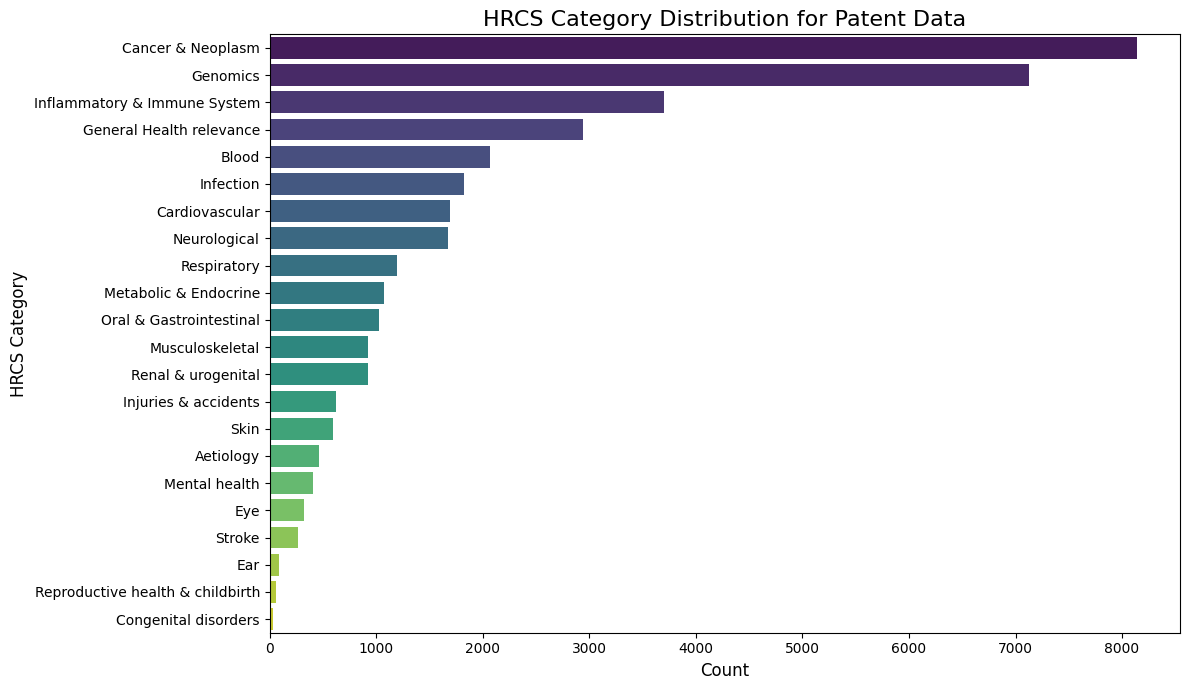

/tmp/ipython-input-4218051524.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='HRCS Category', data=df, palette='viridis')


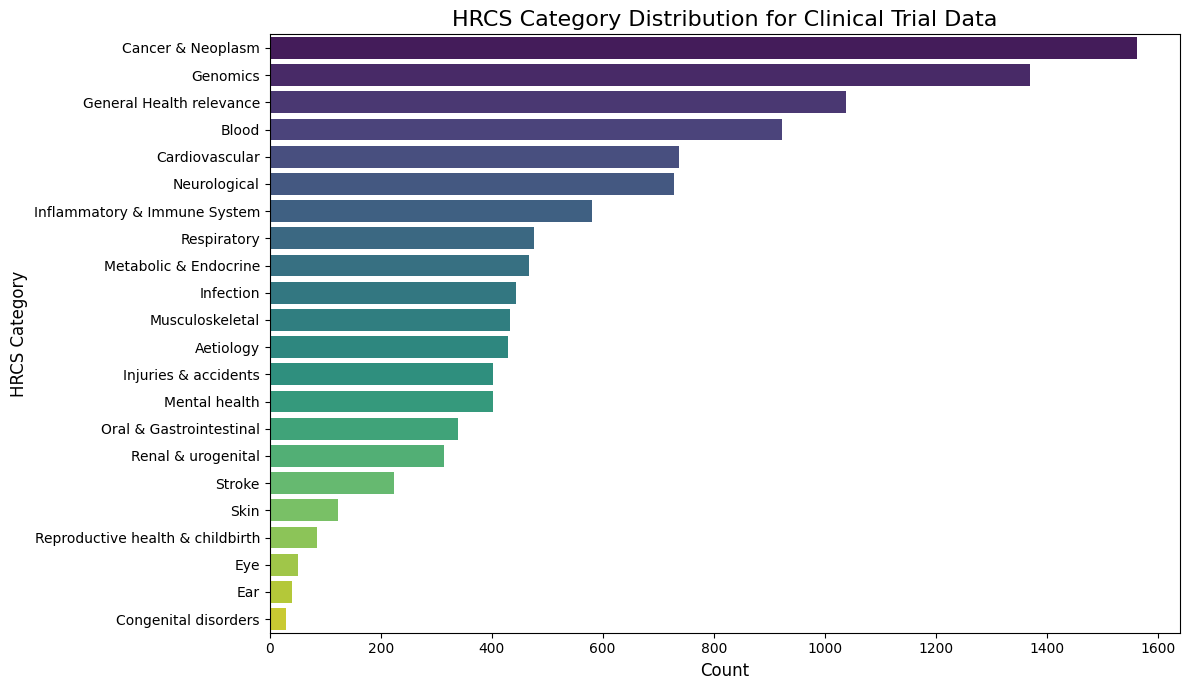

/tmp/ipython-input-4218051524.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='HRCS Category', data=df, palette='viridis')


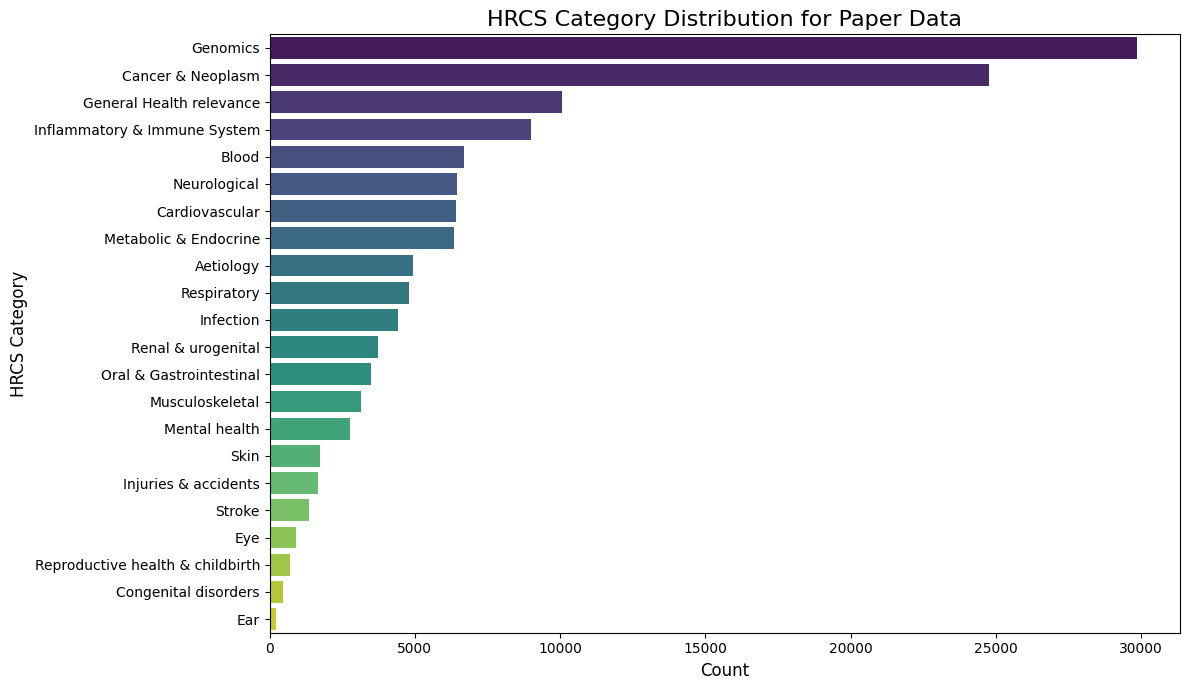

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create and display a bar plot for HRCS category counts
def plot_hrcs_counts(df, title):
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Count', y='HRCS Category', data=df, palette='viridis')
    plt.title(f'HRCS Category Distribution for {title}', fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('HRCS Category', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plotting Patent Data HRCS Counts
plot_hrcs_counts(patent_hrcs_counts, "Patent Data")

# Plotting Clinical Trial Data HRCS Counts
plot_hrcs_counts(trial_hrcs_counts, "Clinical Trial Data")

# Plotting Paper Data HRCS Counts
plot_hrcs_counts(paper_hrcs_counts, "Paper Data")

### Lenght of the trial

In [ ]:
## Setup the dates
trial_df['Start_Date'] = pd.to_datetime(trial_df['Date'])
trial_df['End_Date'] = pd.to_datetime(trial_df['End date'])

## Compute the expected lenght of the trial
trial_df['ExpectedLenght'] = trial_df['End_Date'] - trial_df['Start_Date']
trial_df['ExpectedLenght'] = trial_df['ExpectedLenght'].dt.days

## Compute the lenght to get to compeltion
completed_cond = (trial_df['Status'] == 'COMPLETED')
# Here create a new col but only take values when the condition is met.
trial_df.loc[completed_cond, 'LenghtToCompletion'] = trial_df.loc[completed_cond, 'ExpectedLenght']

## Drop stuff now not useful
trial_df.drop(columns=['End date', 'Date'], inplace=True)

## Create the start and end years
trial_df['Start_year'] = trial_df['Start_Date'].dt.year

Current columns in trial_df: ['Document ID', 'Title', 'Abstract', 'Assignees', 'Claims', 'Status', 'Country', 'Start_Date', 'End_Date', 'ExpectedLenght', 'LenghtToCompletion', 'Start_year', 'Completed', 'Finished', 'hrcs_categories', 'Cat_Aetiology', 'Cat_Blood', 'Cat_Cancer & Neoplasm', 'Cat_Cardiovascular', 'Cat_Congenital disorders', 'Cat_Ear', 'Cat_Eye', 'Cat_General Health relevance', 'Cat_Infection', 'Cat_Inflammatory & Immune System', 'Cat_Injuries & accidents', 'Cat_Mental health', 'Cat_Metabolic & Endocrine', 'Cat_Musculoskeletal', 'Cat_Neurological', 'Cat_Oral & Gastrointestinal', 'Cat_Renal & urogenital', 'Cat_Reproductive health & childbirth', 'Cat_Respiratory', 'Cat_Skin', 'Cat_Stroke', 'Cat_Genomics', 'Assignees_to_encode', 'Country_Argentina, Argentine Republic', 'Country_Australia, Commonwealth of', 'Country_Austria, Republic of|| Europe 27 + UK', 'Country_Barbados', 'Country_Belgium, Kingdom of|| Europe 27 + UK', 'Country_Brazil, Federative Republic of', 'Country_Canad

KeyError: "Column 'Date' not found in the DataFrame."

### Encode completion

Encode Completion
- 'Completed'= 1 if the status==completed
- 'Finished' = 1 if status==completed OR status==terminated OR status==withdrawn

Legend:

- A "terminated" clinical trial is one that has been stopped prematurely and will not resume, meaning both participant recruitment and any ongoing treatment or examination have ceased
- If the entire trial status is marked as "withdrawn," it means the study itself was halted prematurely, before the very first participant was enrolled, and will not resume.

In [ ]:
trial_df['Status'].value_counts()

# Succesfull = Completed
# NOT succesfull = Terminated, withdrawn, suspended (assumption that soemthing wrong has happened)

,count
Status,
COMPLETED,1729
RECRUITING,1493
UNKNOWN,802
NOT_YET_RECRUITING,340
ACTIVE_NOT_RECRUITING,306
TERMINATED,221
WITHDRAWN,132
ENROLLING_BY_INVITATION,72
SUSPENDED,16


In [ ]:
## Create a variables that takes values 1 only if the status is completed
trial_df['Completed'] = np.where(trial_df['Status'] == 'COMPLETED', 1, 0) # -> to become successfull

trial_df['Finished'] = np.where((trial_df['Status'] == 'COMPLETED') |
                                (trial_df['Status'] == 'TERMINATED') |
                                (trial_df['Status'] == 'WITHDRAWN'), 1, 0)

### One hot encoding countries

In [ ]:
# First I reduce the number of countries (83->49)
# I do so by assigning "Other" to countries with less then 5 trials

# Define the count for each country
counts = trial_df['Country'].value_counts()
# Assign True values if a trial is done by a country with <=5 trials
mask = trial_df['Country'].isin(counts[counts<=5].index)
# Copy the country col
trial_df['Country_to_encode'] = trial_df['Country']
# Assign value "Other" to countries with <=5 trials
trial_df.loc[mask,'Country_to_encode'] = 'Other'

In [ ]:
# One hot encode, i.e. create a True/False col for each country in the dataset
trial_df = pd.get_dummies(trial_df,
               columns=['Country_to_encode'],
               prefix='Country')

### One hot Encode Assignee

In [ ]:
# First I reduce the number of assignees
# I do so by considering only assignees among trials finished and with a frequency >2

# Define the count for each country
counts = trial_df[trial_df['Finished'] == 1]['Assignees'].value_counts()
# Assign True values if a trial is done by a country with <=5 trials
mask = trial_df['Assignees'].isin(counts[counts<=3].index)
# Copy the country col
trial_df['Assignees_to_encode'] = trial_df['Assignees']
# Assign value "Other" to countries with <=5 trials
trial_df.loc[mask,'Assignees_to_encode'] = 'Other'

In [ ]:
# THey are still too many
trial_df['Assignees_to_encode'].value_counts()

# Descriptive Analysis

### What is the study phase at the moment of the analysis?

In [ ]:
trial_df['Status'].value_counts()

,count
Status,
COMPLETED,1729
RECRUITING,1493
UNKNOWN,802
NOT_YET_RECRUITING,340
ACTIVE_NOT_RECRUITING,306
TERMINATED,221
WITHDRAWN,132
ENROLLING_BY_INVITATION,72
SUSPENDED,16


### How many trials were completed?

In [ ]:
print('Il dataset contiene', trial_df[completed_cond]['Status'].count(),'(',
      np.round(trial_df[completed_cond]['Status'].count()/trial_df['Status'].count(),2),
      '%) trial completati su un totale di',trial_df['Status'].count(),'trial. \n')

Il dataset contiene 1729 ( 0.34 %) trial completati su un totale di 5111 trial. 



### When they were compelted?

In [ ]:
completed_cond = (trial_df['Status'] == 'COMPLETED')

trial_df[completed_cond]['End_Date'].dt.year.value_counts().sort_index()
# trial_df[completed_cond]['Start_Date'].dt.year.value_counts().sort_index()

,count
End_Date,
2010.0,12
2011.0,20
2012.0,48
2013.0,64
2014.0,84
2015.0,105
2016.0,117
2017.0,135
2018.0,148


Mean/min/MAX lenght

In [ ]:
print('La durata media per completare il trial è stata di',
      trial_df['LenghtToCompletion'].mean().__round__(2),
      '.\n'
      'La durata minima è stata di', trial_df['LenghtToCompletion'].min(),
      'mentre quella massima di', trial_df['LenghtToCompletion'].max())

La durata media per completare il trial è stata di 1050.03 .
La durata minima è stata di 0.0 mentre quella massima di 4503.0


To which categories study were assigned?

# Predictions

## Setup

Setup y and X.

TRAIN = between 2010 and 2020 and finished trials\
TEST  = between 2021 and 2023 and finished trials

y     = completed trials\
X     = Assignee, Country, Start Year, Expected Lenght, Topic

Note.

We condition on ''Finished'' to avoid a censoring bias of trials still in the recruitment phase that may or may not be completed.

In [ ]:
year_split = 2019

train_df    = trial_df[(trial_df['Start_year']>=2010)
                       & (trial_df['Start_year']<=year_split)
                       & (trial_df['Finished']==1)]
test_df     = trial_df[(trial_df['Start_year']>=(year_split+1))
                       & (trial_df['Start_year']<=2023)
                       & (trial_df['Finished']==1)]

y_train     = train_df['Completed']
y_test      = test_df['Completed']

base_features = ['Start_year', 'ExpectedLenght']
# This is a way to select all the columns starting with Cat_ or C_
hrsc_columns        = trial_df.columns.str.startswith('Cat_')
countries_columns   = trial_df.columns.str.startswith('C_')

X_train = pd.concat(
    [train_df[base_features],
     train_df.loc[:, hrsc_columns],
     train_df.loc[:, countries_columns]],
    axis=1)
X_test = pd.concat(
    [test_df[base_features],
     test_df.loc[:, hrsc_columns],
     test_df.loc[:, countries_columns]],
    axis=1)

# X_train       = train_df[features]
# X_test        = test_df[features]


How much of the dataset goes in the train and in the test?

In [ ]:
print('The train dataset contains',train_df['Completed'].count(),'trials, among which',
      train_df[train_df['Completed']==1]['Completed'].count(), 'completed (',
      (train_df[train_df['Completed']==1]['Completed'].count()/train_df['Completed'].count()).__round__(2),'%).')

print('The test dataset contains',test_df['Completed'].count(),'trials, among which',
      test_df[test_df['Completed']==1]['Completed'].count(), 'completed (',
      (test_df[test_df['Completed']==1]['Completed'].count()/test_df['Completed'].count()).__round__(2),'%).')

print('We perform a year-based split, with',
      (train_df['Completed'].count()/trial_df[trial_df['Finished']==1]['Completed'].count()).__round__(2),
      '% observations in the train dataset')

The train dataset contains 1682 trials, among which 1408 completed ( 0.84 %).
The test dataset contains 396 trials, among which 320 completed ( 0.81 %).
We perform a year-based split, with 0.81 % observations in the train dataset


Define the metrics to be used.
## TODO: !!!Check the metrics

In [ ]:
# @jit(nopython=True,fastmath=True)
def TPR(adj_emp,adj_ens):
    """Computes True Positive Rate given empirical and expected binary adjacency matrices."""
    count_tp = (adj_emp * adj_ens).sum()
    count_fn = (adj_emp*(1-adj_ens)).sum()

    soi = count_fn + count_tp
    tpr = count_tp / soi
    return tpr


# @jit(nopython=True,fastmath=True)
def SPC(adj_emp,adj_ens):
    """Computes Specificity given empirical and expected binary adjacency matrices."""
    count_tn = ((1-adj_emp)*(1-adj_ens)).sum()
    count_fp = ((1-adj_emp)*adj_ens).sum()

    soi = count_fp + count_tn
    spc = count_tn / soi
    return spc



# @jit(nopython=True,fastmath=True)
def PPV(adj_emp,adj_ens):
    """Computes Precision given empirical and expected binary adjacency matrices."""
    count_tp = (adj_emp*adj_ens).sum()
    count_fp = ((1-adj_emp)*adj_ens).sum()
    soi = count_fp + count_tp
    ppv = count_tp / soi
    return ppv

# @jit(nopython=True,fastmath=True)
def ACC(adj_emp,adj_ens):
    """Computes Accuracy given empirical and expected binary adjacency matrices."""

    count_tp = (adj_emp*adj_ens).sum()
    count_fp = ((1-adj_emp)*adj_ens).sum()
    count_fn = (adj_emp*(1-adj_ens)).sum()
    count_tn = ((1-adj_emp)*(1-adj_ens)).sum()

    soi = count_fn + count_tp + count_tn + count_fp
    son = count_tp + count_tn
    acc = son / soi
    return acc

# @jit(nopython=True,fastmath=True)
def BACC(adj_emp,adj_ens):
    """Computes Balanced Accuracy given empirical and expected binary adjacency matrices."""
    tpr_model = TPR(adj_emp,adj_ens)
    spc_model = SPC(adj_emp,adj_ens)


    bacc = (tpr_model + spc_model)/2.
    return bacc

# @jit(nopython=True,fastmath=True)
def F1_score(adj_emp,adj_ens):
    """Computes F1 Score given empirical and expected binary adjacency matrices."""
    tpr_model = TPR(adj_emp,adj_ens)
    ppv_model = PPV(adj_emp,adj_ens)


    f1 = 2*tpr_model*ppv_model/(tpr_model+ppv_model)
    return f1

## LOGIT

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


def logit_reg(X_train, y_train, X_test, y_test, penalty=None,save_model_path=None,score_path=None):
    """
    Train a Logistic Regression model, make predictions, and return classification metrics including ROC AUC.

    Parameters:
    - y: Dependent Variable
    - X: Matrix of covaraites
    - penalty: Type of regularization. Default is 'none'
    - yr_train: Default 2018. It specificies the max year taken to compute the training set
    - yr_test: Default 2019. It specificies the year taken to compute the test set

    Returns:
    - Dataframe containing classification metrics and ROC AUC score
    """

    # Combine X and y to ensure rows with NaN in either are dropped together
    train_data = pd.concat([pd.DataFrame(X_train), pd.Series(y_train, name="y")], axis=1).dropna()
    test_data = pd.concat([pd.DataFrame(X_test), pd.Series(y_test, name="y")], axis=1).dropna()

    X_train = train_data.drop(columns=["y"]).values
    y_train = train_data["y"].values
    X_test = test_data.drop(columns=["y"]).values
    y_test = test_data["y"].values

    # check if X and y have the same dimension
    if X_train.shape[0] == y_train.shape[0]:
        # Scale matrix X using standard scalers
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.fit_transform(X_test)

        # Create the model with the specified penalty
        logit_reg = LogisticRegression(penalty=penalty,max_iter=1000)

        logit_reg.fit(X_train_scaled,y_train)

        logit_pred = logit_reg.predict_proba(X_test_scaled)[:,1]



        logit_scores_df = pd.Series({'TPR':TPR(y_test,logit_pred),
                                     'SPC':SPC(y_test,logit_pred),
                                     'PPV':PPV(y_test,logit_pred),
                                     'ACC':ACC(y_test,logit_pred),
                                     'BACC':BACC(y_test,logit_pred),
                                     'F1':F1_score(y_test,logit_pred),
                                     'ROC':roc_auc_score(y_test,logit_pred)})

        # if save_model_path:
        #     with open(save_model_path, 'wb') as model_file:
        #         pickle.dump(logit_reg, model_file)


    # Raise error if the number of rows in the datasets are different
    else:
        raise ValueError("Number of rows in X_train must be equal to the number of rows in y_train.")

    df_scores = logit_scores_df.to_frame().T
    if score_path:
        df_scores.to_csv(score_path)

    return df_scores

In [ ]:
logit_scores = logit_reg(X_train=X_train,
                         X_test=X_test,
                         y_train=y_train,
                         y_test=y_test)

logit_scores.T

,0
TPR,0.850660
SPC,0.281060
PPV,0.832830
ACC,0.741343
BACC,0.565860
F1,0.841651
ROC,0.734745


## RF

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, cross_validate


def rf_classifier_rand_search(X_train, y_train, X_test, y_test,
                  n_estimators = [10,15,20,25,30,50,75,100],
                  max_depth    = [10,20,30,50],
                  max_features = ['log2', 'sqrt'],
                  n_iter=10,
                  random_state = 101,
                  score_path = None, save_model_path=None,
                  ):

    """
    Train a Random Forest model, make predictions, and return classification metrics including ROC AUC.

    Parameters:
    - y: Dependent Variable
    - X: Matrix of covariates
    - n_estimators: Number of trees in the forest.
    - max_depth: Maximum depth of a tree.
    - max_features: Number of features to consider when looking for the best split.

    Returns:
    - DataFrame containing classification metrics and ROC AUC score
    """

    feature_names = X_train.columns


  # Combine X and y to ensure rows with NaN in either are dropped together
    train_data = pd.concat([pd.DataFrame(X_train), pd.Series(y_train, name="y")], axis=1).dropna()
    test_data = pd.concat([pd.DataFrame(X_test), pd.Series(y_test, name="y")], axis=1).dropna()

    X_train = train_data.drop(columns=["y"]).values
    y_train = train_data["y"].values
    X_test = test_data.drop(columns=["y"]).values
    y_test = test_data["y"].values

    # check if X and y have the same dimension
    if X_train.shape[0] == y_train.shape[0]:
        # Scale matrix X using standard scalers
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        raise ValueError("Number of rows in X_train must be equal to the number of rows in y_train.")


    param_dist = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features
    }

    rf_importance = pd.DataFrame()

    rf = RandomForestClassifier()

    random_search = RandomizedSearchCV(estimator=rf,
                                       param_distributions=param_dist,
                                       n_iter=n_iter,
                                       cv=5,
                                       scoring='roc_auc',
                                       random_state=101)

    random_search.fit(X_train_scaled, y_train)

    # Get the best model from the random search
    best_rf = random_search.best_estimator_

    # Make out-of-sample predictions
    y_pred = best_rf.predict_proba(X_test_scaled)[:,1]


    rf_scores_df = pd.Series({'TPR':TPR(y_test,y_pred),
                                    'SPC':SPC(y_test,y_pred),
                                    'PPV':PPV(y_test,y_pred),
                                    'ACC':ACC(y_test,y_pred),
                                    'BACC':BACC(y_test,y_pred),
                                    'F1':F1_score(y_test,y_pred),
                                    'ROC':roc_auc_score(y_test,y_pred)})


    importance_values = best_rf.feature_importances_
    importance_col_name = 'Importance_Best_Model'
    rf_importance[importance_col_name] = importance_values
    rf_importance.insert(0, 'Variable', feature_names)

    # if save_model_path:
    #     with open(save_model_path, 'wb') as model_file:
    #         pickle.dump(best_rf, model_file)


    df_scores = rf_scores_df.to_frame().T
    if score_path:
        df_scores.to_csv(score_path)


    return df_scores, rf_importance

In [ ]:
rf_scores, rf_feat = rf_classifier_rand_search(X_train=X_train,
                         X_test=X_test,
                         y_train=y_train,
                         y_test=y_test)

In [ ]:
rf_scores.T

,0
TPR,0.813138
SPC,0.220056
PPV,0.814462
ACC,0.699314
BACC,0.516597
F1,0.813799
ROC,0.645066


In [ ]:
rf_feat.sort_values(by='Importance_Best_Model',ascending=False)

,Variable,Importance_Best_Model
1,ExpectedLenght,0.206086
0,Start_year,0.135442
72,C_United States of America,0.080833
4,Cat_Cancer & Neoplasm,0.050506
9,Cat_General Health relevance,0.039635
...,...,...
47,"C_Kazakhstan, Republic of|| Europe 27 + UK",0.000000
51,C_Malaysia,0.000000
50,"C_Lithuania, Republic of|| Europe 27 + UK",0.000000
61,"C_Saudi Arabia, Kingdom of",0.000000


## XGB

In [ ]:
def xgb_classifier_rand_search(X_train, y_train, X_test, y_test,
                   param_distributions=None,
                   n_iter=10,
                   random_state=None,
                   save_model_path=None,n_jobs=8,
                #    start_year = 2010, final_year = 2018,
                   score_path = None,
              year_col = 'yr'):
    """
    Train an XGBoost model, make predictions, and return classification metrics including ROC AUC.

    Parameters:
    - y: Dependent Variable
    - X: Matrix of covariates
    - param_distributions: Dictionary specifying the hyperparameter distributions for RandomizedSearchCV.
    - n_iter: Number of parameter settings that are sampled.
    - random_state: Seed for random number generator.
    - save_model_path: Filepath to save the best model. If None, the model won't be saved.


    Returns:
    - DataFrame containing classification metrics and ROC AUC score
    """

    # feature_names = X_train.columns
    param_distributions = {'max_depth': (np.random.uniform(3, 18,5)).astype(int),
          'gamma': np.random.uniform(1,9,5),
          'reg_alpha' : (np.random.uniform(40,180,5)).astype(int),
          'reg_lambda' : np.random.uniform(0,1,5),
          'colsample_bytree' : np.random.uniform(0.5,1,5),
          'min_child_weight' : (np.random.uniform(0, 10,5)).astype(int),
          'n_estimators': [180],
          'seed': [0]    }

  # Combine X and y to ensure rows with NaN in either are dropped together
    train_data = pd.concat([pd.DataFrame(X_train), pd.Series(y_train, name="y")], axis=1).dropna()
    test_data = pd.concat([pd.DataFrame(X_test), pd.Series(y_test, name="y")], axis=1).dropna()

    X_train = train_data.drop(columns=["y"]).values
    y_train = train_data["y"].values
    X_test = test_data.drop(columns=["y"]).values
    y_test = test_data["y"].values

    # check if X and y have the same dimension
    if X_train.shape[0] == y_train.shape[0]:
        # Scale matrix X using standard scalers
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        raise ValueError("Number of rows in X_train must be equal to the number of rows in y_train.")

    # Create model instance
    xgb = XGBClassifier(objective='binary:logistic')

    random_search = RandomizedSearchCV( xgb,
                                        param_distributions=param_distributions,
                                        n_iter=n_iter,
                                        scoring='roc_auc',
                                        cv=5,
                                        random_state=random_state,
                                        n_jobs=n_jobs)

    # Fit the model
    random_search.fit(X_train_scaled, y_train)

    # Get the best model from the search
    best_xgb = random_search.best_estimator_

    # Make out-of-sample predictions
    y_pred = best_xgb.predict_proba(X_test_scaled)[:,1]

    xgb_scores_df = pd.Series({'TPR':TPR(y_test,y_pred),
                                    'SPC':SPC(y_test,y_pred),
                                    'PPV':PPV(y_test,y_pred),
                                    'ACC':ACC(y_test,y_pred),
                                    'BACC':BACC(y_test,y_pred),
                                    'F1':F1_score(y_test,y_pred),
                                    'ROC':roc_auc_score(y_test,y_pred)})

    df_scores = xgb_scores_df.to_frame().T


    return df_scores, best_xgb

In [ ]:
xgb_scores, xgb_best = xgb_classifier_rand_search(X_train=X_train,
                         X_test=X_test,
                         y_train=y_train,
                         y_test=y_test)

In [ ]:
xgb_scores.T

,0
TPR,0.837725
SPC,0.162275
PPV,0.808081
ACC,0.708093
BACC,0.500000
F1,0.822636
ROC,0.500000
